# Use REBOUND commit 07d10d1e0d96d9e945ae97a78db9b2028c3ef069 on oldMLstability branch of dtamayo/rebound fork

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import rebound
import dask.dataframe as dd
from scipy.stats import norm, ks_2samp
plt.style.use('paper')

In [2]:
csvpath = '../csvs/random/random_features/'
distpath = '../../stabilitydataset/data/random/initial_conditions/runs/'
#save data
#info.to_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_{0}.csv".format(info.shape[0]))

#FILTER DATA (between 1e4 and 1e7)
info = pd.read_csv("../csvs/random/Gaussian_Fits_266.csv", index_col=0)

#fully integrated data
short_feats = pd.read_csv("../csvs/random/deltatimes.csv", index_col =0 )
subsystem = info["ID"].values.astype(int)
sub_short = short_feats.loc[subsystem]
print(sub_short.shape)

#filtered data params
filtered = sub_short[ (sub_short["t"]>1e4) & (sub_short["t"]<1e7) &
                    (sub_short["t_shadow"]>1e4 ) & (sub_short["t_shadow"]<1e7) ] 

print(filtered.shape)
filtered_inds = filtered.index
#df.loc[df['column_name'].isin(some_values)]
df = info.loc[info["ID"].isin(filtered_inds)] 
df = df[['ID', 'Mean', 'Sigma']]
df.head()

(266, 3)
(248, 3)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,1007,0.133196,5.587629,0.464593,0.014738,0.010563,2.423315e-08
1,1021,0.181262,6.003999,0.327314,0.010287,0.007410,5.811603e-09
2,1025,0.153687,5.794418,0.385985,0.012358,0.008756,1.170601e-08
3,1041,0.127597,5.730234,0.494415,0.015324,0.011150,2.919534e-08
4,10518,0.144064,6.465849,0.431597,0.013325,0.009608,1.638141e-08


In [3]:
df.shape

(248, 7)

In [4]:
df = df[(df['Mean'] > 4) & (df['Mean'] < 7)]
df.shape

(244, 7)

In [5]:
labels = pd.read_csv('../../MLstability/training_data/random/labels.csv', index_col=0)
labels.head()

,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,1.235665e+07,8.315223e+07,False
1,0000001.bin,1.348749e+05,2.133072e+05,False
2,0000002.bin,1.276428e+04,9.321863e+03,False
3,0000003.bin,1.000000e+09,1.000000e+09,True
4,0000004.bin,8.791890e+01,8.791890e+01,False


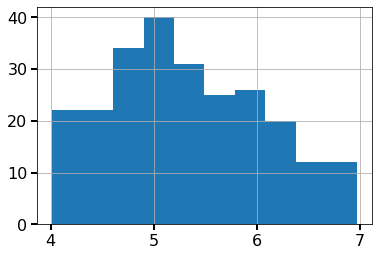

In [6]:
df['Mean'].hist()

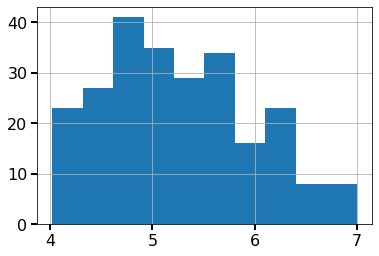

In [7]:
np.log10(labels.loc[df['ID']]['instability_time']).hist()

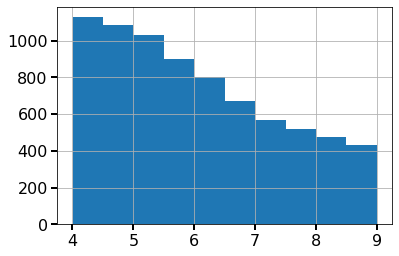

In [8]:
mask = (labels['instability_time']>1e4) & (labels['instability_time']<9.99e8)
np.log10(labels[mask]['instability_time']).hist()

In [9]:
mask.sum()/labels.shape[0]

0.30452

In [10]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def runsplit(row):
    tmax = 1e7
    ID = int(row['ID'])
    row['instability_time'] = labels.loc[ID, 'instability_time']

    np.random.seed(3)
    data =pd.read_csv(csvpath + "Sys_{0}_1e8.csv".format(ID), index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    # normal we want to match
    test = np.random.normal(loc=row["Mean"], scale=row["Sigma"], size = data.shape[0])

    #ks test
    try:
        statistic, KSpval = ks_2samp(data, test)
    except:
        statistic, KSpval = 0,0
        
    row['KSpval'] = KSpval
    
    file = distpath+"ic{0:0=7d}.bin".format(ID)
    sim = rebound.Simulation.from_file(file)
    sim.ri_whfast.keep_unsynchronized = 1
    sim.collision_resolve=collision
    sim.init_megno(seed=0)

    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)
    P0 = sim.particles[1].P

    row['tlyap10'] = np.nan
    row['megno10'] = np.nan
    row['Nlyap10'] = np.nan
    
    sim.integrate(row['instability_time']/10, exact_finish_time=0)
    row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
    if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
        row['tlyap10'] = sim.t
    row['megno10'] = sim.calculate_megno()
    row['Nlyap10'] = row['instability_time']  / row['tlyap10']
    
    return row

# We don't get exactly the same instability time when rerunning stopping along the way because the original integrations are using unsynced positions to detect collisions and megno syncs them. But that's fine. We always get very close, because it's once the orbits are crossing that we start finding collisions (synced or unsynced). This is a demonstration that the exact details of detecting collisions doesn't matter. We've also already checked reproducibility when we do a single sim.integrate (see test_notebooks) and here we just want the lyap times

In [11]:
%%time
ddf = dd.from_pandas(df, npartitions=24)
testres = runsplit(df.iloc[0])
df = ddf.apply(runsplit, axis=1, meta=pd.DataFrame([testres])).compute(scheduler='processes')

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simula

CPU times: user 4.66 s, sys: 905 ms, total: 5.57 s
Wall time: 3min 29s


In [18]:
df.to_csv(csvpath+'random1e7featuressplit.csv')